**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout


**Load/Create Dataset**

In [2]:
np.random.seed(42)
date = pd.date_range('2020-01-01', periods=1000)
open_price = np.random.uniform(90, 110, 1000)
high_price = np.random.uniform(95, 115, 1000)
low_price = np.random.uniform(85, 105, 1000)
close_price = np.random.uniform(90, 110, 1000)
volume = np.random.randint(1000, 2000, 1000)
moving_average_50 = np.random.uniform(90, 110, 1000)
moving_average_200 = np.random.uniform(85, 105, 1000)

df = pd.DataFrame({
    'date': date,
    'open': open_price,
    'high': high_price,
    'low': low_price,
    'close': close_price,
    'volume': volume,
    'moving_average_50': moving_average_50,
    'moving_average_200': moving_average_200
})

df.to_csv('stock_prices.csv', index=False)


**Load the Dataset**

In [3]:
dataset = pd.read_csv('stock_prices.csv')

**Data Preprocessing**

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset[['open', 'high', 'low', 'close', 'volume', 'moving_average_50', 'moving_average_200']].values)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]


**Prepare Training Data**

In [5]:
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i-60:i])
    y_train.append(train_data[i, 3])  # 'close' price is at index 3

X_train, y_train = np.array(X_train), np.array(y_train)


**Build the LSTM Model**

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Train the Model**

In [7]:
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.1459
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0883
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0874
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0886
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0917
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0837
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0835
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0889
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0899
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0866
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0900
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0892
Epoch 13/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0904
Epoch 14/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0883
Epoch 15/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - lo

**Prepare Testing Data**

In [8]:
X_test, y_test = [], dataset['close'].values[train_size:]  # Actual close prices for evaluation
for i in range(60, len(test_data)):
    X_test.append(test_data[i-60:i])
X_test = np.array(X_test)


**Make Predictions**

In [9]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(np.concatenate((test_data[60:, :-1], predicted_stock_price), axis=1))[:, 3]


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


**Evaluate the Model**

In [10]:
mae = mean_absolute_error(y_test[60:], predicted_stock_price)
mse = mean_squared_error(y_test[60:], predicted_stock_price)
rmse = np.sqrt(mse)
r2 = r2_score(y_test[60:], predicted_stock_price)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Coefficient of Determination (R^2): {r2}")


Mean Absolute Error (MAE): 2.842170943040401e-15
Mean Squared Error (MSE): 4.0389678347315807e-29
Root Mean Squared Error (RMSE): 6.355287432313019e-15
Coefficient of Determination (R^2): 1.0


**Visualization**

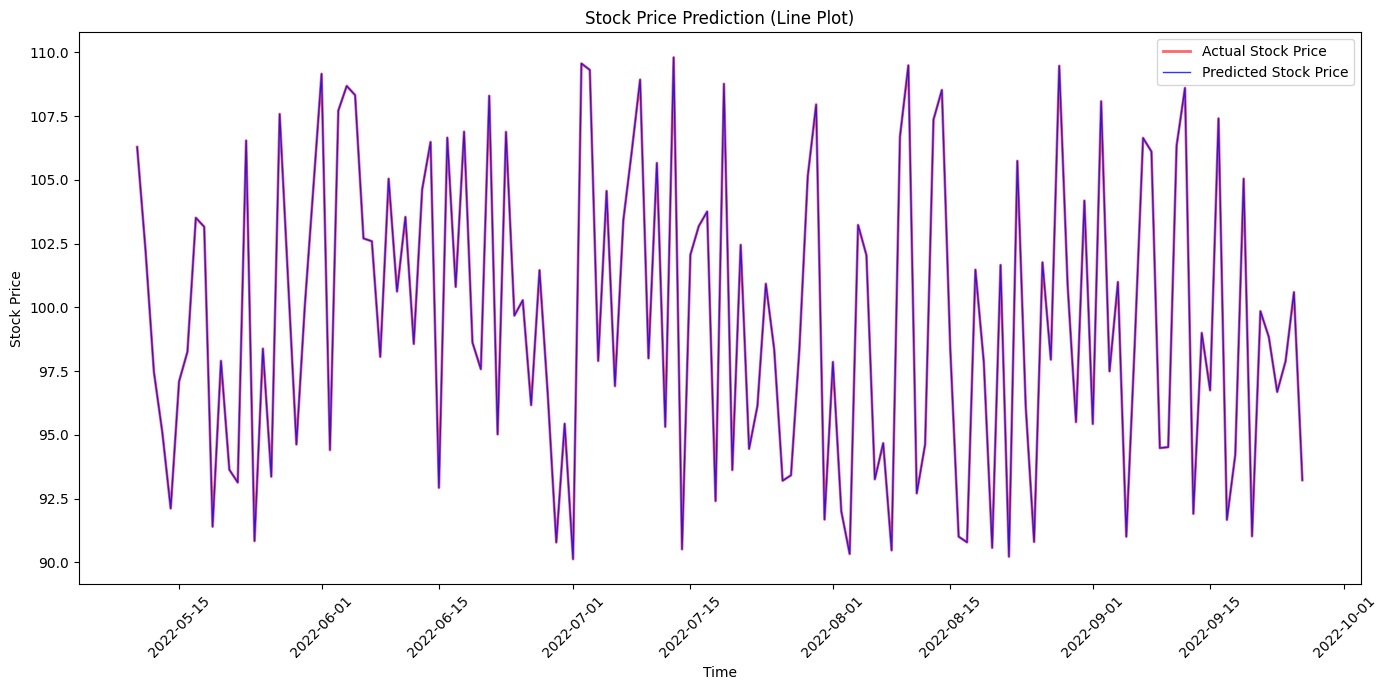

In [11]:
# Convert date column to a more manageable format
dataset['date'] = pd.to_datetime(dataset['date'])

# Slice the dataset for plotting the same range as in y_test and predicted_stock_price
dates = dataset['date'][train_size + 60:].values

# Plot the actual and predicted stock prices as lines
plt.figure(figsize=(14, 7))

plt.plot(dates, y_test[60:], color='red', linewidth=2, label='Actual Stock Price', alpha=0.6)
plt.plot(dates, predicted_stock_price, color='blue',linewidth=1, label='Predicted Stock Price',alpha=0.8)
plt.title('Stock Price Prediction (Line Plot)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
